In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib as mpl
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
os.environ["OMP_NUM_THREADS"] = '1'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'

In [154]:
water = pd.read_csv('C:/k_digital/source/data/data_tr_city.csv')

In [155]:
water['target'] = water['구미 혁신도시배수지 유출유량 적산차']
water = water.drop('구미 혁신도시배수지 유출유량 적산차', axis=1)

In [158]:
water['datetime'] = water['datetime'].astype('datetime64[ns]')

In [159]:
water = water.set_index('datetime')
water

,target
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


In [160]:
water.index = water.index.to_period('h')

In [161]:
water.index

PeriodIndex(['2017-01-01 01:00', '2017-01-01 02:00', '2017-01-01 03:00',
             '2017-01-01 04:00', '2017-01-01 05:00', '2017-01-01 06:00',
             '2017-01-01 07:00', '2017-01-01 08:00', '2017-01-01 09:00',
             '2017-01-01 10:00',
             ...
             '2020-12-31 14:00', '2020-12-31 15:00', '2020-12-31 16:00',
             '2020-12-31 17:00', '2020-12-31 18:00', '2020-12-31 19:00',
             '2020-12-31 20:00', '2020-12-31 21:00', '2020-12-31 22:00',
             '2020-12-31 23:00'],
            dtype='period[H]', name='datetime', length=35063)

<AxesSubplot:xlabel='datetime'>

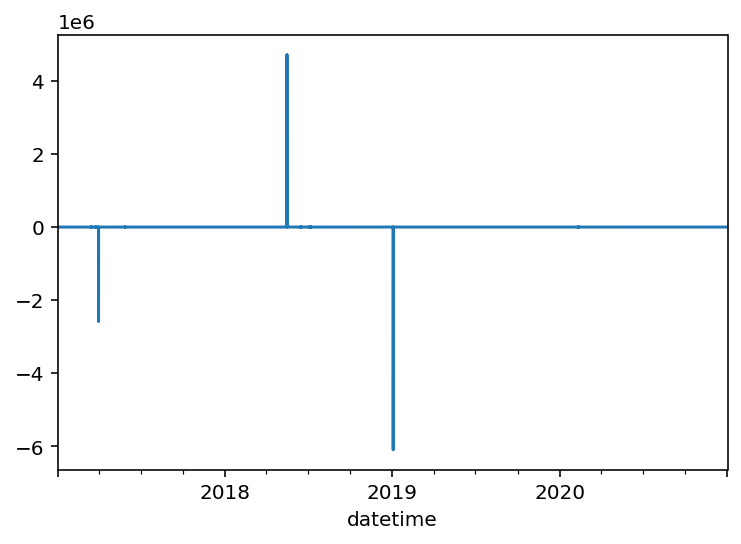

In [162]:
water.target.plot()

In [163]:
water.sort_values(by='target', ascending=False)

,target
datetime,
2018-05-15 20:00,4720655.0
2017-05-27 10:00,4999.0
2017-05-28 06:00,3357.0
2017-05-31 08:00,2591.0
2017-05-28 15:00,2550.0
...,...
2018-06-14 22:00,NaN
2018-07-04 12:00,NaN
2018-07-06 11:00,NaN


In [164]:
water.target = water.target.round(0)

In [165]:
water.target.replace(0, np.NaN, inplace=True)

<AxesSubplot:xlabel='datetime'>

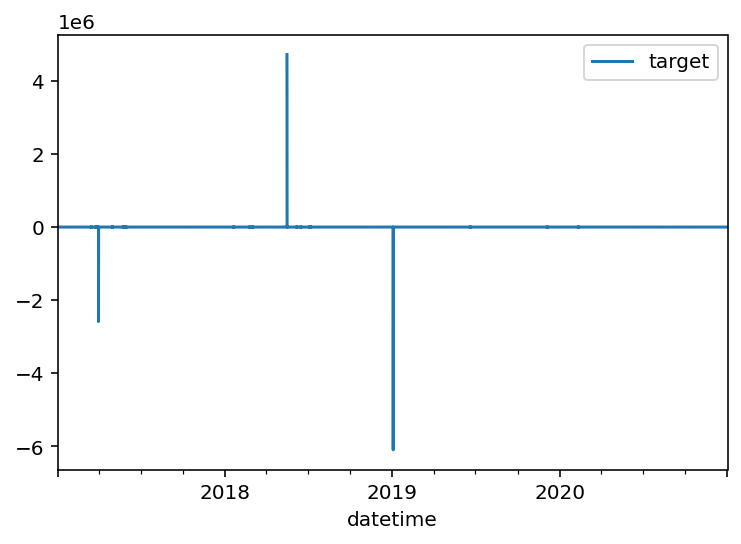

In [166]:
water.plot()

In [167]:
water[water.target == water.target.max()] = np.nan  # 위아래 평균값 넣기

In [168]:
for i in range(2):
    water[water.target == water.target.min()] = np.nan  # np.NaN

<AxesSubplot:xlabel='datetime'>

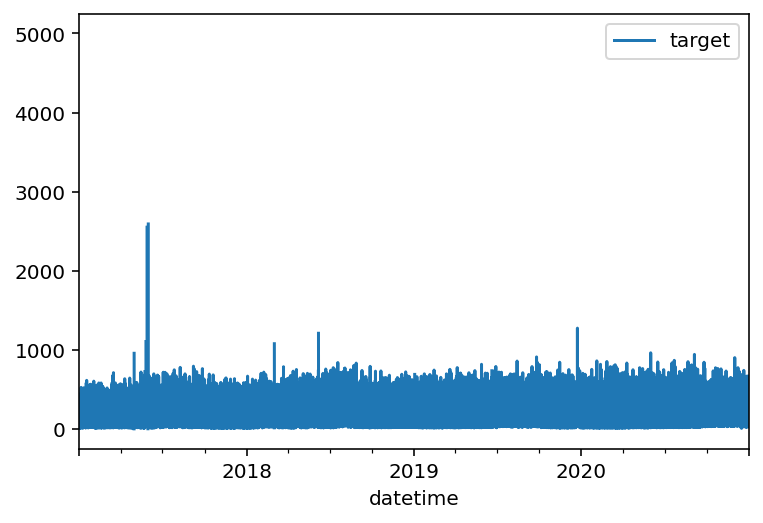

In [169]:
water.plot()

In [170]:
water[(water.index.year == 2017) & (water.index.month == 5) & (water.target.isna())]

,target
datetime,
2017-05-23 16:00,NaN
2017-05-23 18:00,NaN
2017-05-23 23:00,NaN
2017-05-24 21:00,NaN
2017-05-25 00:00,NaN
...,...
2017-05-31 03:00,NaN
2017-05-31 04:00,NaN
2017-05-31 05:00,NaN


### 5월 23일 결측치처리 - 진행중

In [171]:
print(water[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24) & (water.index.hour >= 14)])

                  target
datetime                
2017-05-23 14:00   684.0
2017-05-23 15:00   104.0
2017-05-23 16:00     NaN
2017-05-23 17:00   664.0
2017-05-23 18:00     NaN
2017-05-23 19:00   366.0
2017-05-23 20:00    56.0
2017-05-23 21:00   234.0
2017-05-23 22:00   486.0
2017-05-23 23:00     NaN
2017-05-24 14:00   303.0
2017-05-24 15:00   366.0
2017-05-24 16:00   154.0
2017-05-24 17:00   129.0
2017-05-24 18:00   171.0
2017-05-24 19:00   344.0
2017-05-24 20:00   175.0
2017-05-24 21:00     NaN
2017-05-24 22:00   670.0
2017-05-24 23:00   151.0


In [172]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)])

                  target
datetime                
2017-05-23 15:00   104.0
2017-05-23 16:00     NaN
2017-05-23 17:00   664.0
2018-05-23 15:00   227.0
2018-05-23 16:00   133.0
2018-05-23 17:00   402.0
2019-05-23 15:00    84.0
2019-05-23 16:00   228.0
2019-05-23 17:00   346.0
2020-05-23 15:00   456.0
2020-05-23 16:00   260.0
2020-05-23 17:00   147.0


In [173]:
filled = water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)].sum()

In [174]:
fill = water.target[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)].sum()

In [175]:
print((filled / fill).round(2))

1.17


In [176]:
water[water.index == '2017-05-23 16:00'] = water.target[water.index == '2019-05-23 16:00'] * 1.17
water[water.index == '2017-05-23 17:00'] = water.target[water.index == '2019-05-23 17:00'] * 1.17

In [177]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 17) & (water.index.hour <= 19)])

                  target
datetime                
2017-05-23 17:00  404.82
2017-05-23 18:00     NaN
2017-05-23 19:00  366.00
2018-05-23 17:00  402.00
2018-05-23 18:00  179.00
2018-05-23 19:00  369.00
2019-05-23 17:00  346.00
2019-05-23 18:00  145.00
2019-05-23 19:00  319.00
2020-05-23 17:00  147.00
2020-05-23 18:00  293.00
2020-05-23 19:00  520.00


In [178]:
filled = water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 17) & (water.index.hour <= 19)].sum()
fill_1 = water.target[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 17) & (water.index.hour <= 19)].sum()
fill_2 = water.target[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 17) & (water.index.hour <= 19)].sum()

In [179]:
tot_fill = (fill_1+fill_2)/2

In [180]:
(filled/tot_fill).round(2)

0.88

In [181]:
(water.target[water.index == '2018-05-23 18:00'][0] + water.target[
    water.index == '2018-05-24 18:00'][0])/2

180.5

In [182]:
water[water.index == '2017-05-23 18:00'] = ((
    water.target[water.index == '2018-05-23 18:00'][0] + water.target[
        water.index == '2018-05-24 18:00'][0]) / 2) * 0.88

<AxesSubplot:xlabel='datetime'>

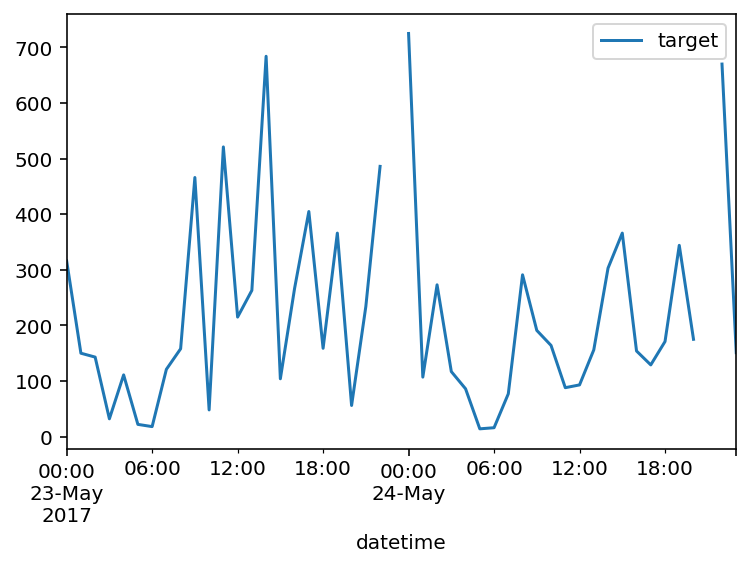

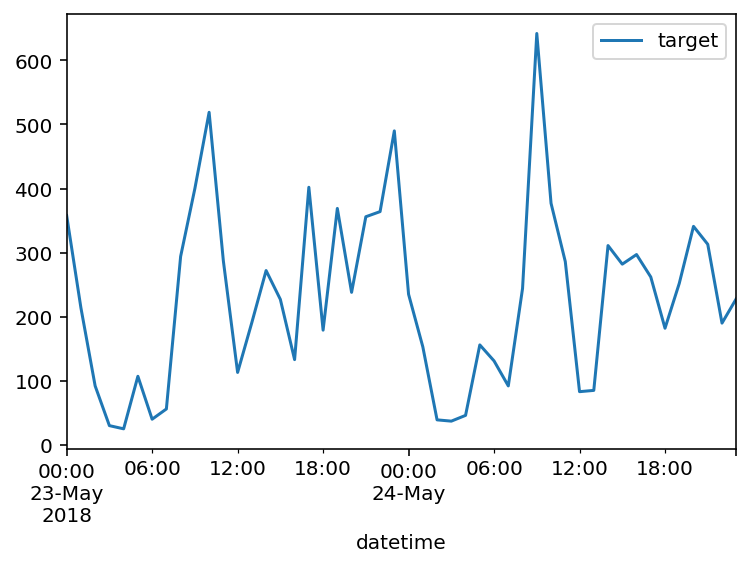

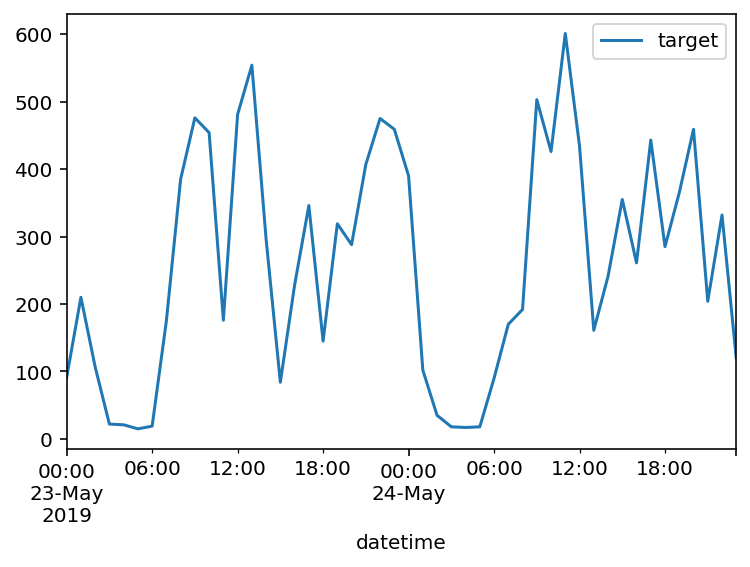

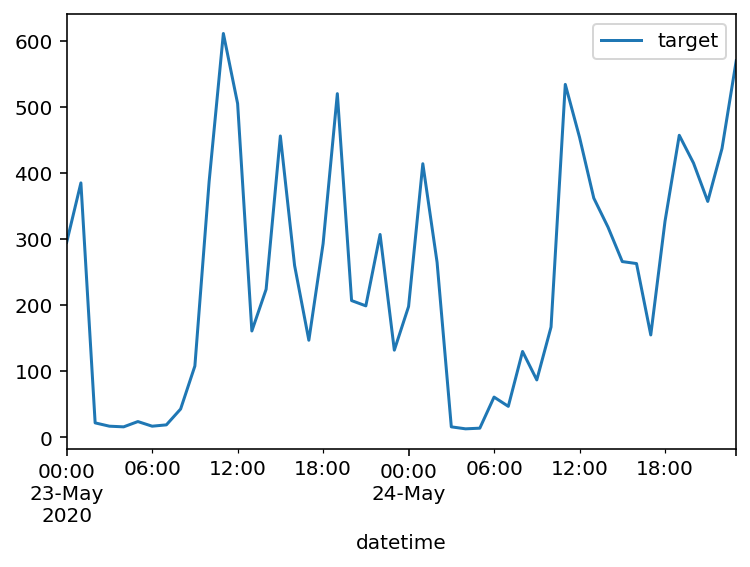

In [183]:
water[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2020) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()

In [184]:
water[(water.index.year == 2017) & (water.target.isna())]
# 보간법 일부 가능, 다른 년도의 값들을 보고 채워넣어야 할 듯.

,target
datetime,
2017-03-14 21:00,NaN
2017-03-24 15:00,NaN
2017-03-28 17:00,NaN
2017-03-30 16:00,NaN
2017-04-29 14:00,NaN
...,...
2017-05-31 03:00,NaN
2017-05-31 04:00,NaN
2017-05-31 05:00,NaN


In [185]:
water[(water.index.year == 2017) & (water.index.month == 3)] = water[
    (water.index.year == 2017) & (water.index.month == 3)].interpolate()

In [186]:
water[(water.index.year == 2017) & (water.target.isna())]
# 3월만 보간법 사용

,target
datetime,
2017-04-29 14:00,NaN
2017-04-29 16:00,NaN
2017-04-29 17:00,NaN
2017-04-29 18:00,NaN
2017-04-29 19:00,NaN
...,...
2017-05-31 03:00,NaN
2017-05-31 04:00,NaN
2017-05-31 05:00,NaN


In [187]:
water[(water.index.year == 2018) & (water.target.isna())]
# 6월 6일의 결측값을 제외하고는 보간법이 가능함

,target
datetime,
2018-01-19 15:00,NaN
2018-02-23 17:00,NaN
2018-03-02 06:00,NaN
2018-03-02 07:00,NaN
2018-03-02 08:00,NaN
2018-05-15 19:00,NaN
2018-05-15 20:00,NaN
2018-06-06 04:00,NaN
2018-06-06 05:00,NaN


In [188]:
water[(water.index.year == 2018) & (water.index.month != 6)] = water[
    (water.index.year == 2018) & (water.index.month != 6)].interpolate()

In [189]:
water[(water.index.year == 2018) & (water.target.isna())]
# 6월 6일 제외한 값 보간법 사용

,target
datetime,
2018-06-06 04:00,NaN
2018-06-06 05:00,NaN
2018-06-06 06:00,NaN
2018-06-06 07:00,NaN
2018-06-06 08:00,NaN
2018-06-06 12:00,NaN
2018-06-06 13:00,NaN
2018-06-06 14:00,NaN
2018-06-06 15:00,NaN


In [190]:
water[(water.index.year == 2019) & (water.target.isna())]
# 보간법 사용가능

,target
datetime,
2019-01-02 15:00,NaN
2019-06-19 20:00,NaN
2019-12-04 19:00,NaN


In [191]:
water[(water.index.year == 2019)] = water[(water.index.year == 2019)].interpolate()

In [192]:
water[(water.index.year == 2019) & (water.target.isna())]
# 값 확인

,target
datetime,


In [193]:
water[(water.index.year == 2020) & (water.target.isna())]
# 각 결측치가 바로 붙어있긴 하지만 두개 밖에 없기 때문에 보간법 사용가능

,target
datetime,
2020-02-10 14:00,NaN
2020-02-10 15:00,NaN


In [194]:
water[(water.index.year == 2020)] = water[(water.index.year == 2020)].interpolate()

In [195]:
water[(water.index.year == 2020) & (water.target.isna())]
# 값 확인

,target
datetime,


In [196]:
water.target.isna().sum()

132

In [197]:
water

,target
datetime,
2017-01-01 01:00,138.0
2017-01-01 02:00,237.0
2017-01-01 03:00,128.0
2017-01-01 04:00,14.0
2017-01-01 05:00,11.0
...,...
2020-12-31 19:00,328.0
2020-12-31 20:00,347.0
2020-12-31 21:00,335.0


In [202]:
train_2019 = water[water.index.year == 2019]

In [203]:
train_2020 = water[water.index.year == 2020]

In [207]:
train = train_2019 + train_2020

In [210]:
train.reset_index(level=0, inplace=True)

In [215]:
train_2019

,target
datetime,
2019-01-01 00:00,114.0
2019-01-01 01:00,83.0
2019-01-01 02:00,68.0
2019-01-01 03:00,90.0
2019-01-01 04:00,112.0
...,...
2019-12-31 19:00,108.0
2019-12-31 20:00,170.0
2019-12-31 21:00,268.0


<AxesSubplot:xlabel='datetime'>

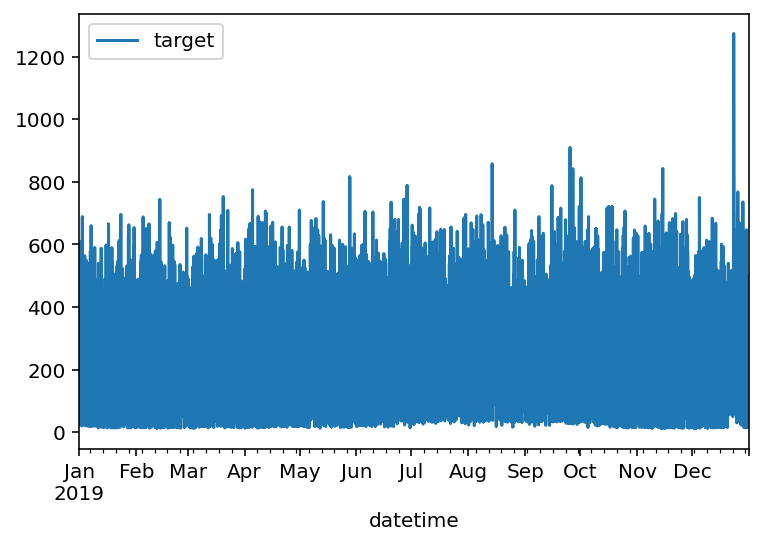

In [234]:
train_2019.plot()

In [7]:
from pmdarima.arima import auto_arima

In [216]:
model_arima= auto_arima(train_2019,trace=True, error_action='ignore',
                        start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,
                        stepwise=False,seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=113427.338, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=113146.235, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113270.157, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=112860.779, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=112793.407, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.86 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Tot

In [230]:
auto_arima_model = auto_arima(train_2019, 
                              start_p=0, max_p=3, 
                              start_q=0, max_q=3, 
                              seasonal=False,
                              d = 1,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=113427.338, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=113146.235, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113270.157, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=112860.779, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.93 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=112793.407, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.52 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Tot

In [231]:
auto_arima_model = auto_arima(train_2019, 
                              start_p=0, max_p=3, 
                              start_q=0, max_q=3, 
                              seasonal=False,
                              d = 2,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=120588.693, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.89 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=118358.342, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=11.64 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=116663.643, Time=0.43 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=11.50 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=11.95 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=115920.453, Time=0.56 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.31 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.72 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0] intercept
Total f

In [232]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8760
Model:               SARIMAX(3, 1, 0)   Log Likelihood              -56391.704
Date:                Tue, 22 Nov 2022   AIC                         112793.407
Time:                        15:06:10   BIC                         112828.797
Sample:                    01-01-2019   HQIC                        112805.466
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0455      1.732      0.026      0.979      -3.349       3.440
ar.L1         -0.1819      0.011    -17.261      0.000      -0.203      -0.161
ar.L2         -0.2287      0.011    -21.692      0.000      -0.249      -0.208
ar.L3         -0.0888      0.011     -7.895      0.000      -0.111      -0.067
sigma2       2.29e+04    326.298     70.170      0.000    2.23e+04    2.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):               205.45
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [242]:
pred_2020_01_01model_arima.predict(n_periods = 25)

In [248]:
## 서브미션 시간대별로 300개 가량 periods를 재학습시켜서 도출

In [246]:
pred_2020_01_01

2020-01-01 00:00    332.901863
2020-01-01 01:00    343.550953
2020-01-01 02:00    358.172142
2020-01-01 03:00    356.328446
2020-01-01 04:00    352.420378
2020-01-01 05:00    352.299912
2020-01-01 06:00    353.424615
2020-01-01 07:00    353.640066
2020-01-01 08:00    353.399852
2020-01-01 09:00    353.339860
2020-01-01 10:00    353.432020
2020-01-01 11:00    353.495757
2020-01-01 12:00    353.513869
2020-01-01 13:00    353.533269
2020-01-01 14:00    353.565390
2020-01-01 15:00    353.598955
2020-01-01 16:00    353.629234
2020-01-01 17:00    353.658651
2020-01-01 18:00    353.688848
2020-01-01 19:00    353.719392
2020-01-01 20:00    353.749771
2020-01-01 21:00    353.780031
2020-01-01 22:00    353.810320
2020-01-01 23:00    353.840646
2020-01-02 00:00    353.870969
Freq: H, dtype: float64

In [247]:
train_2020

,target
datetime,
2020-01-01 00:00,233.0
2020-01-01 01:00,40.0
2020-01-01 02:00,67.0
2020-01-01 03:00,151.0
2020-01-01 04:00,18.0
...,...
2020-12-31 19:00,328.0
2020-12-31 20:00,347.0
2020-12-31 21:00,335.0


<AxesSubplot:>

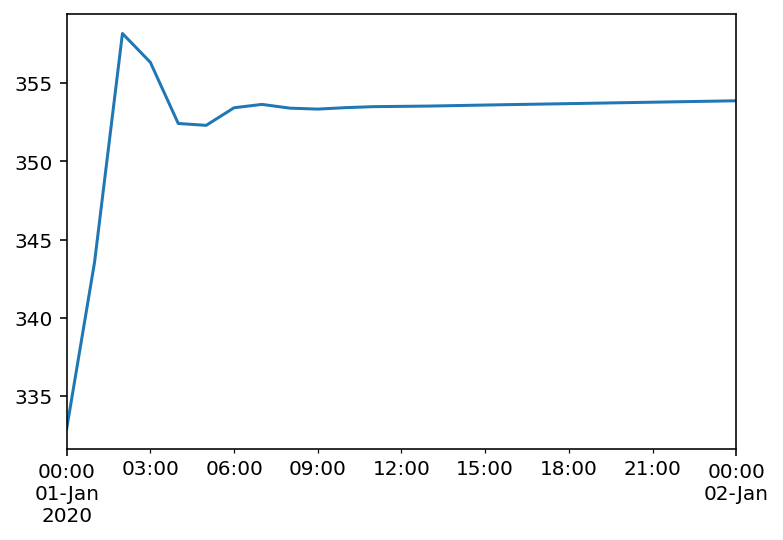

In [250]:
pred_2020_01_01.plot()

In [254]:
test = train_2020[(train_2020.index.month == 1) & (train_2020.index.day == 1)]

<AxesSubplot:xlabel='datetime'>

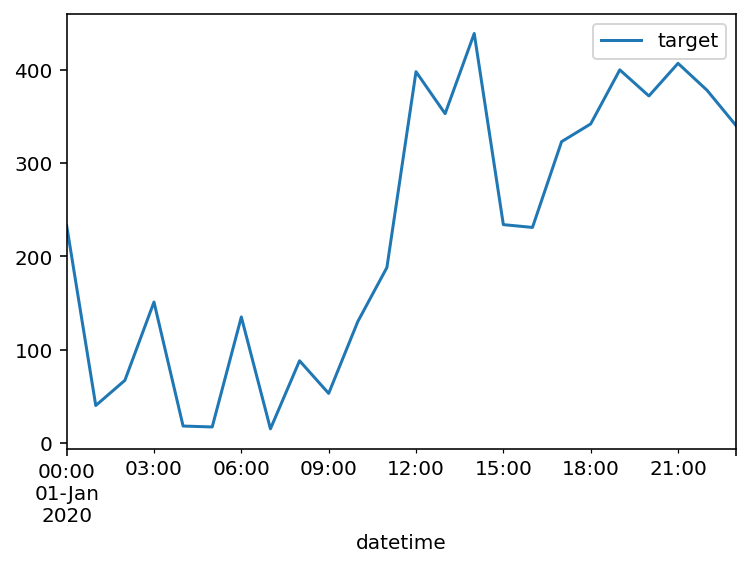

In [255]:
test.plot()

In [256]:
from datetime import datetime



datetime.today()            # 현재 날짜 가져오기


datetime.datetime(2022, 11, 22, 16, 24, 48, 682859)

In [259]:
train_2020.index[0]

Period('2019-12-31 23:00', 'H')

In [262]:
train_2020[train_2020.index == train_2020.index[2]]

,target
datetime,
2020-01-01 02:00,67.0
